In [1]:
import sys
sys.path.insert(0,r"E:\Github\scqubits")

# Initialization

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import scqubits as qubit
import numpy as np
import tqdm

**Example: Transmon qubit**

To illustrate basic functionality built into QCircuit, we consider the implementation of the transmon qubit as an example. 

# Defining circuit topology

First step is to define a circuit topology.

In [3]:
Transmon = qubit.Circuit()
Transmon.add_element(qubit.JosephsonJunction('JJ1'), ['GND', '1'])
Transmon.add_element(qubit.JosephsonJunction('JJ2'), ['1', '2'])
Transmon.add_element(qubit.Capacitance('Cq'), ['GND', '1'])

Which has the following circuit schematic 

In [4]:
import SchemDraw as schem
import SchemDraw.elements as e

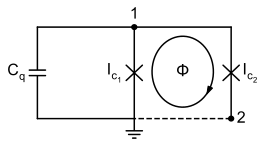

In [5]:
d = schem.Drawing()
d.add(e.CAP, d='up', l=d.unit, label='$C_q$')
d.add(e.LINE,d='right', l=d.unit)
E1=d.add(e.DOT,label='1')
E2=d.add(e.JJ, d='down', l=d.unit, label='$I_{c_1}$')
E6=d.add(e.GND,d='right')
E5=d.add(e.LINE,xy=E1.end,d='right', l=d.unit)
E3=d.add(e.JJ, d='down', l=d.unit, botlabel='$I_{c_2}$')
E4=d.add(e.DOT,botlabel='2',d='down')
d.loopI([E5,E3,E4,E2], d='cw',theta1=330, theta2=-30, label='$\Phi$',pad=0.3)
d.add(e.LINE,xy=E4.end,d='left',ls='--')
d.add(e.LINE,d='left')
d.draw()

# Parametrizing Hamiltonian

1) Specify the node variables, which can be used either to calculate wavefunctions or to set the external flux, voltage values

In [6]:
phi1 = qubit.Variable('φ1')
f = qubit.Variable('f')
ng = qubit.Variable('ng')

here phi1 is a variable used for Hamiltonian parametrization, f - external flux trough the transmon's SQUID and ng - charge offset

The method used for calculating qubit parameters based on numerical solution of the Schrödinger equation, which is a second-order differential equation. To solve it the grid for the "computational variables" should be specified and by specifing the grid it's shown that this variable will be used for computation   

In [7]:
phi1.create_grid(32,1)
Transmon.add_variable(phi1)
Transmon.add_variable(f)
Transmon.add_variable(ng)

# Mapping nodal phases to variables

The most important step is to...

which works in a following way:  
**A*x=b**, b is a node vector=['GND', '1', '2']  
x is a variable vector= ['ϕ1','f','ng'] and A describes the relationship between them  
f - external flux, and should be specified as an additional node and a variable. In our case it equals to the second node   
ng - charge offset. ('GND' node)

In [9]:
Transmon.map_nodes_linear(['GND', '1' , '2'], 
                          ['φ1', 'f','ng' ], 
                          np.asarray([[0,0,1],
                                      [1,0,0],
                                      [0,1,1]]))

## check that everything was specified correctly

In [12]:
import sympy
Cq, E_J1, E_J2 = \
    sympy.symbols('Cq, E_J1, E_J2')
Transmon.find_element('Cq').set_capacitance(Cq)
Transmon.find_element('JJ1').set_critical_current(E_J1)
Transmon.find_element('JJ2').set_critical_current(E_J2)

In [13]:
sympy.nsimplify(Transmon.symbolic_lagrangian())

-E_J1*(1 - cos(ng - φ1)) - E_J2*(1 - cos(f + ng - φ1)) + \partial_tng*(Cq*\partial_tng/2 - Cq*\partial_tφ1/2) + \partial_tφ1*(-Cq*\partial_tng/2 + Cq*\partial_tφ1/2)

In [14]:
sympy.nsimplify(Transmon.symbolic_hamiltonian())

E_J1*(1 - cos(ng - φ1)) + E_J2*(1 - cos(f + ng - φ1)) + \partial_tng*(Cq*\partial_tng - I*\partial_{φ1})/2 - I*\partial_{φ1}*(\partial_tng - I*\partial_{φ1}/Cq)/2

# Eigenvalues using circuit tools

number of states should be less than grid discretization:   
create_grid(num,period)  
**num-1>num_states**

In [19]:
import tqdm

In [16]:
voltage_steps = 16
flux_steps=100
num_states=30
energies = np.zeros((voltage_steps,num_states), dtype=np.float)
Ej1 = 15
Ej2 = 5
Ec = 0.200
Transmon.find_element('JJ1').set_critical_current(Ej1)
Transmon.find_element('JJ2').set_critical_current(Ej2)
Transmon.find_element('Cq').set_capacitance(1/(8*Ec))
f_value = 0
ng_value = 0

for ng_id, ng_value in tqdm.tqdm(enumerate(np.linspace(-2, 2, voltage_steps)/8*Ec)):
    f.set_parameter(f_value, 0)
    ng.set_parameter(0, ng_value)
    Transmon.calculate_potentials()
    [eigenenergies, eigenfunctions] = Transmon.diagonalize_phase(num_states=num_states)
    energies[ng_id, :] = eigenenergies

0it [00:00, ?it/s]C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
16it [00:00, 65.34it/s]


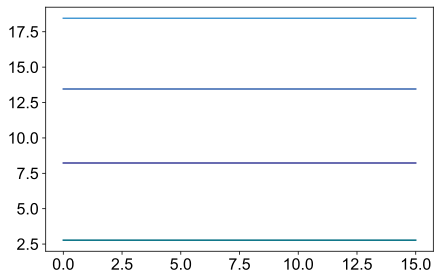

In [18]:
plt.plot(energies[:,:4])

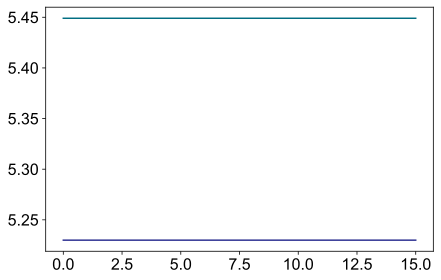

In [17]:
plt.plot((energies[:,1]-energies[:,0]))
plt.plot((energies[:,2]-energies[:,1]))

In [22]:
flux_steps=100
num_states=30
energies = np.zeros((flux_steps,num_states), dtype=np.float)
Ej1 = 15
Ej2 = 5
Ec = 0.200
Transmon.find_element('JJ1').set_critical_current(Ej1)
Transmon.find_element('JJ2').set_critical_current(Ej2)
Transmon.find_element('Cq').set_capacitance(1/(8*Ec))
f_value = 0
ng_value = 0

for f_id, f_value in tqdm.tqdm(enumerate(np.linspace(-np.pi, np.pi, flux_steps))):
    f.set_parameter(f_value, 0)
    ng.set_parameter(0, ng_value)
    Transmon.calculate_potentials()
    [eigenenergies, eigenfunctions] = Transmon.diagonalize_phase(num_states=num_states)
    energies[f_id, :] = eigenenergies

0it [00:00, ?it/s]C:\Users\Ivan\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
100it [00:00, 170.25it/s]


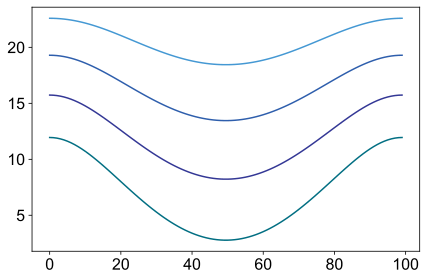

In [23]:
plt.plot(energies[:,:4])

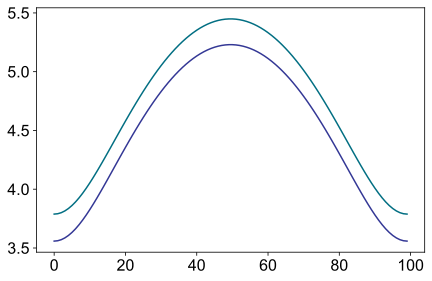

In [24]:
plt.plot((energies[:,1]-energies[:,0]))
plt.plot((energies[:,2]-energies[:,1]))